 Modelos Generativos Profundos: De Autoencoders a VAEs con PyTorch
==============================================================================

 **Curso de Deep Learning**

 **Objetivo:** Este script explora de manera didáctica y con rigor teórico la transición
 de un Autoencoder (AE) simple a un Autoencoder Variacional (VAE) como un
 modelo generativo probabilístico. Utilizaremos el canónico dataset MNIST
 para visualizar y comprender las diferencias fundamentales en la estructura
 del espacio latente y las capacidades generativas de cada arquitectura.

 Inspirado en la célebre frase de Richard Feynman, “Lo que no puedo crear,
 no lo entiendo”, nuestro objetivo no es solo comprimir y reconstruir imágenes,
 sino "entender" la distribución subyacente de los datos para poder "crear"
 nuevas muestras a partir de ella.


## 1. Fundamento Teórico: El Rol de las Variables Latentes

Los datos de alta dimensionalidad, como las imágenes, a menudo residen en una
variedad (manifold) de dimensionalidad mucho menor. Los factores que explican
la variabilidad en los datos (ej., el estilo de un dígito, su rotación) son
**variables latentes** ($z$), ya que no están explícitamente etiquetadas.

Un modelo de variable latente postula que los datos observados $x$ se generan
a partir de estas variables latentes no observadas $z$ a través de un proceso
estocástico. El modelo se define por la distribución conjunta $p(x, z) = p(x|z)p(z)$:

- **Prior $p(z)$:** Una distribución simple sobre el espacio latente (ej. una
  Gaussiana isotrópica $\mathcal{N}(0, I)$).
- **Likelihood (Decoder) $p_\theta(x|z)$:** Una distribución condicional,
  parametrizada por una red neuronal (el *decoder* con parámetros $\theta$), que
  genera un dato $x$ a partir de una variable latente $z$.

El principal desafío es el aprendizaje. Para entrenar este modelo usando máxima
verosimilitud, necesitaríamos maximizar la **verosimilitud marginal** (o *evidence*):

$$ p_\theta(x) = \int p_\theta(x|z)p(z)dz $$

Esta integral es intratable en la mayoría de los casos, ya que requiere integrar
sobre todas las posibles configuraciones del espacio latente. Además, para realizar
inferencia (ej., para saber qué características ha aprendido el modelo), necesitamos
la **distribución posterior** $p_\theta(z|x) = \frac{p_\theta(x|z)p(z)}{p_\theta(x)}$,
que también es intratable.

Aquí es donde divergen los AEs y los VAEs.
- Los **AEs** ignoran esta formulación probabilística y aprenden un mapeo determinista.
- Los **VAEs** abordan el problema de frente utilizando **Inferencia Variacional**.

## 2. Configuración del Entorno

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

# Configuración del dispositivo (GPU si está disponible, si no CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# Parámetros del modelo
LATENT_DIM = 2
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 1e-3



Usando dispositivo: cuda


## 3. Carga y Preprocesamiento del Dataset MNIST

In [2]:
# Descargar y cargar los datos de entrenamiento
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Descargar y cargar los datos de prueba
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Crear DataLoaders
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Verificamos las dimensiones de un batch
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

IMAGE_SIZE = X.shape[2] * X.shape[3]


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:22<00:00, 450kB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 140kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:03<00:00, 442kB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.89MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


## Parte I: El Autoencoder (AE) Básico

Un Autoencoder es una red neuronal que aprende a comprimir (codificar) y
luego a reconstruir (decodificar) datos de manera no supervisada.

1.  **Encoder**: Mapea la entrada $x$ a una representación latente determinista $z = f(x)$.
2.  **Decoder**: Reconstruye la entrada original a partir de $z$, $\hat{x} = g(z)$.

Se entrena minimizando la **pérdida de reconstrucción** (ej. MSE o BCE) entre
$x$ y $\hat{x}$.

**Limitación clave:** El espacio latente de un AE no está regularizado. No hay
nada que obligue a que las codificaciones tengan una estructura particular. Esto
lo hace deficiente para la generación de nuevas muestras.

Arquitectura del Autoencoder:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
--- Entrenando Autoencoder Básico ---
Epoch 1
-------------------------------
loss: 544.922485  [    0/60000]
loss: 195.924866  [12800/60000]
loss: 181.970642  [25600/60000]
loss: 177.181274  [38400/60000]
loss: 175.818573  [51200/60000]
Epoch 2
-------------------------------
loss: 168.502045  [    0/60000]
loss: 165.898178  [12800/60000]
loss: 168.725525  [25600/60000]
loss: 169.096130  [38400/60000]
loss: 163.713074  [51200/60000]
Epoch 3
-------------------------------
loss: 156.415314  [    0/60000]
loss: 167.171661  [12800/60000]
loss: 168.495270  [25600/60000]
loss: 160.160751  [38400/600

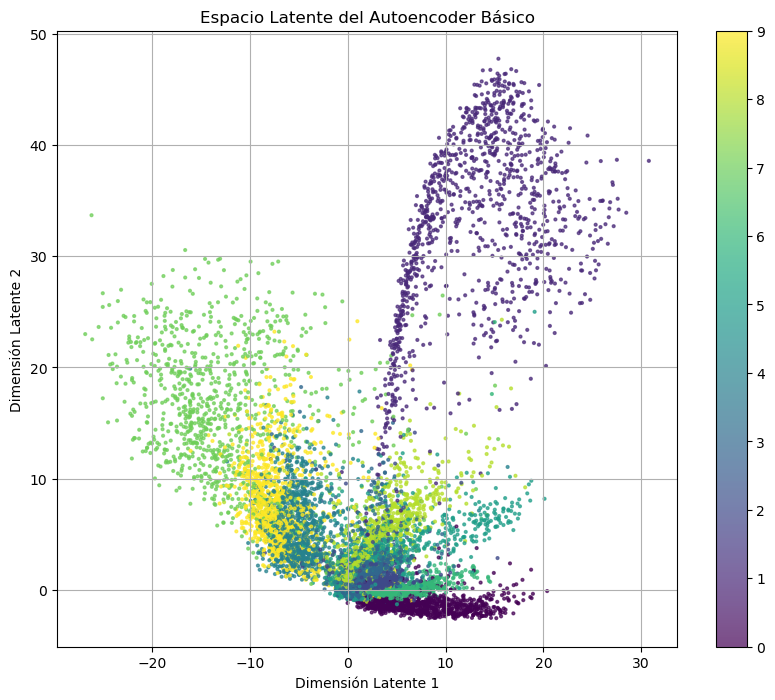

Observación: Los clusters de dígitos están mal definidos y se superponen.
No hay una estructura clara que el modelo pueda usar para generar nuevas muestras.


In [3]:
## 4.1. Implementación del Autoencoder en PyTorch

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(IMAGE_SIZE, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, IMAGE_SIZE),
            nn.Sigmoid()  # Sigmoide para que los píxeles estén en [0, 1]
        )

    def forward(self, x):
        # Aplanamos la imagen de entrada
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

ae_model = Autoencoder(LATENT_DIM).to(device)
print("Arquitectura del Autoencoder:")
print(ae_model)

loss_fn_ae = nn.BCELoss(reduction='sum') # BCE es bueno para reconstrucción de píxeles
optimizer_ae = torch.optim.Adam(ae_model.parameters(), lr=LEARNING_RATE)

##############################################################################

# ## 4.2. Entrenamiento del Autoencoder

def train_ae(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Aplanar la imagen para la pérdida y el modelo
        X_flat = X.view(X.size(0), -1)

        # Computar la predicción y la pérdida
        pred = model(X)
        loss = loss_fn(pred, X_flat)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss/len(X):>7f}  [{current:>5d}/{size:>5d}]")

print("--- Entrenando Autoencoder Básico ---")
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_ae(train_dataloader, ae_model, loss_fn_ae, optimizer_ae)
print("Entrenamiento del AE completado!")

##############################################################################

# ## 4.3. Evaluación del Espacio Latente del AE

def plot_ae_latent_space(model, dataloader):
    model.eval()
    latent_space = []
    labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X_flat = X.view(X.size(0), -1).to(device)
            encoded = model.encoder(X_flat)
            latent_space.append(encoded.cpu().numpy())
            labels.append(y.numpy())

    latent_space = np.concatenate(latent_space)
    labels = np.concatenate(labels)

    plt.figure(figsize=(10, 8))
    plt.scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap='viridis', s=4, alpha=0.7)
    plt.colorbar()
    plt.title('Espacio Latente del Autoencoder Básico')
    plt.xlabel('Dimensión Latente 1')
    plt.ylabel('Dimensión Latente 2')
    plt.grid(True)
    plt.show()
    print("Observación: Los clusters de dígitos están mal definidos y se superponen.")
    print("No hay una estructura clara que el modelo pueda usar para generar nuevas muestras.")

plot_ae_latent_space(ae_model, test_dataloader)



## Parte II: El Autoencoder Variacional (VAE)

El VAE es un modelo generativo que aborda las limitaciones del AE. En lugar de
mapear la entrada a un único punto en el espacio latente, el encoder del VAE
mapea la entrada a una **distribución de probabilidad** sobre el espacio latente,
típicamente una Gaussiana $\mathcal{N}(\mu, \sigma^2)$.

### 5.1. Fundamento: La Cota Inferior de la Evidencia (ELBO)

Como maximizar $p_\theta(x)$ es intratable, la Inferencia Variacional propone
aproximar la verdadera posterior $p_\theta(z|x)$ con una distribución más simple
$q_\phi(z|x)$ (nuestro encoder), parametrizada por $\phi$. Queremos que $q_\phi(z|x)$
sea lo más parecida posible a $p_\theta(z|x)$, lo que se logra minimizando su
divergencia KL.

Minimizar $D_{KL}(q_\phi(z|x) || p_\theta(z|x))$ es equivalente a maximizar una
cantidad llamada **Evidence Lower Bound (ELBO)**:

$$ \log p_\theta(x) \ge \mathcal{L}(\theta, \phi; x) = \mathbb{E}_{z \sim q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) || p(z)) $$

La función de pérdida de un VAE es el negativo de la ELBO. Sus dos componentes son:

1.  **Término de Reconstrucción**: $-\mathbb{E}_{z \sim q_\phi(z|x)}[\log p_\theta(x|z)]$.
    Mide qué tan bien el decoder reconstruye la entrada. En la práctica, se implementa
    como una pérdida de entropía cruzada binaria (BCE) o error cuadrático medio (MSE).

2.  **Término de Regularización (Divergencia KL)**: $D_{KL}(q_\phi(z|x) || p(z))$.
    Este es el componente crucial. Obliga a la distribución del encoder $q_\phi(z|x)$ a
    mantenerse cercana a la distribución *prior* $p(z)$ (ej., $\mathcal{N}(0, I)$).
    Esto organiza el espacio latente, haciéndolo continuo y completo, lo que es
    esencial para la generación.

### 5.2. El Truco de la Reparametrización

Un problema clave es que el paso de muestreo $z \sim q_\phi(z|x)$ es estocástico
y, por lo tanto, no es diferenciable. No podemos propagar gradientes a través de él.

El **truco de la reparametrización** resuelve esto. En lugar de muestrear $z$
directamente, muestreamos una variable aleatoria simple $\epsilon \sim \mathcal{N}(0, I)$
y luego calculamos $z$ de forma determinista:

$$ z = \mu + \sigma \odot \epsilon $$

Ahora, los gradientes pueden fluir a través de $\mu$ y $\sigma$ hacia los parámetros
del encoder $\phi$, permitiendo el entrenamiento con backpropagation.


Arquitectura del Variational Autoencoder:
VAE(
  (encoder_net): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=2, bias=True)
  (decoder_net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

--- Entrenando Variational Autoencoder ---
Epoch 1
-------------------------------
loss: 549.175537  [    0/60000]
loss: 207.397812  [12800/60000]
loss: 186.097473  [25600/60000]
loss: 183.400253  [38400/60000]
loss: 186.032501  [51200/60000]
Epoch 2
-------------------------------
loss: 179.380264  [    0/60000]
loss: 187.534103  [12800/60000]
loss: 178.470856  [25600/60000]
loss: 166.774490  [38400/60000]
loss: 168.521484  [51200/60000]
Epoch 3
-------------------------------
loss: 164.962418  [    0/60000]
loss:

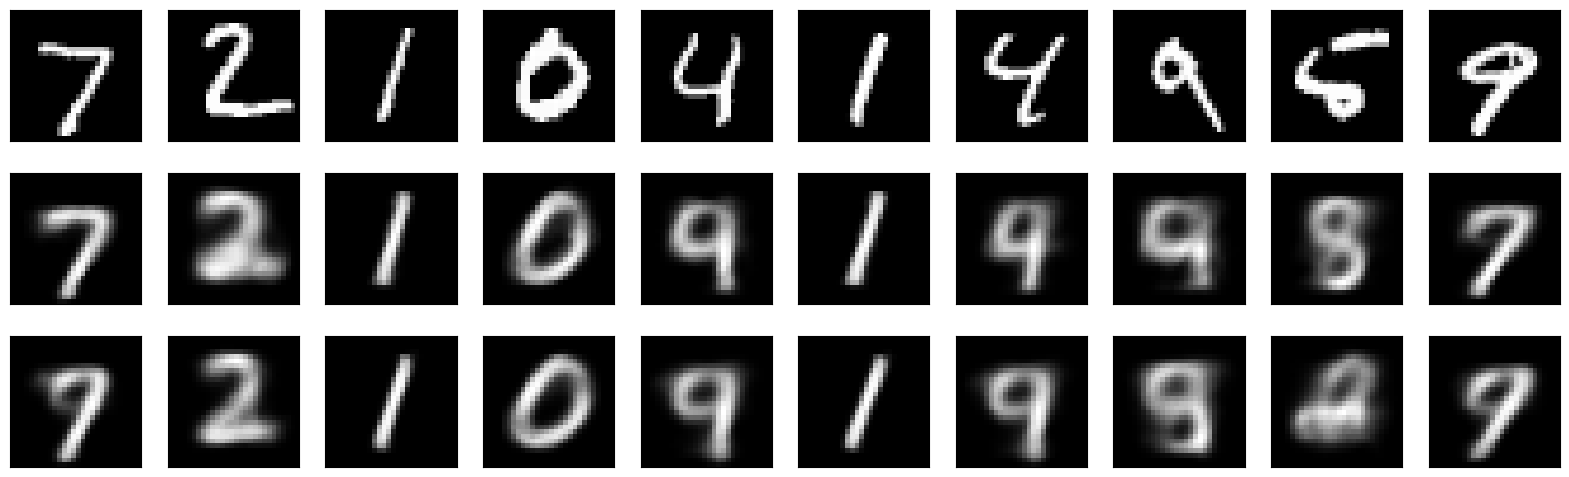

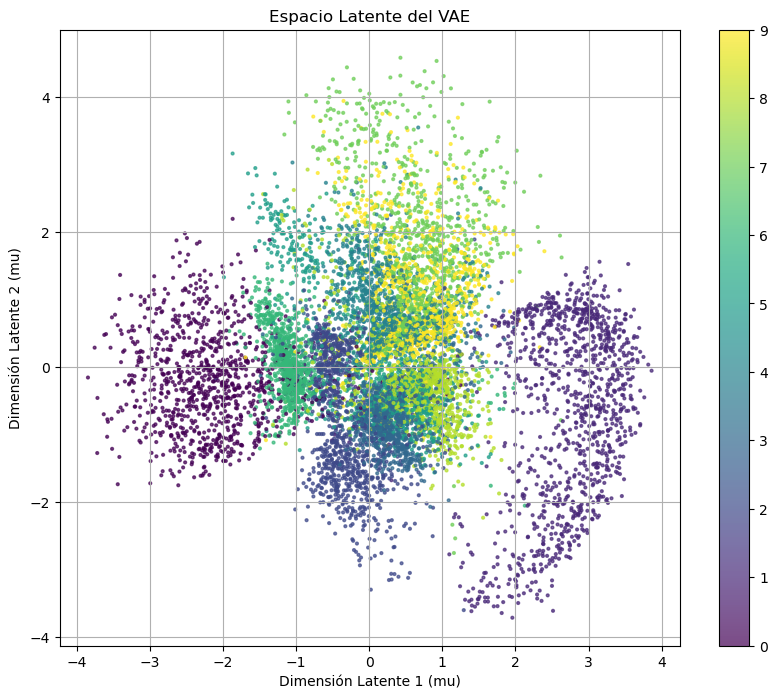

Observación: El espacio latente está mucho más estructurado y centrado.
Los clusters son distinguibles y el espacio entre ellos es significativo.


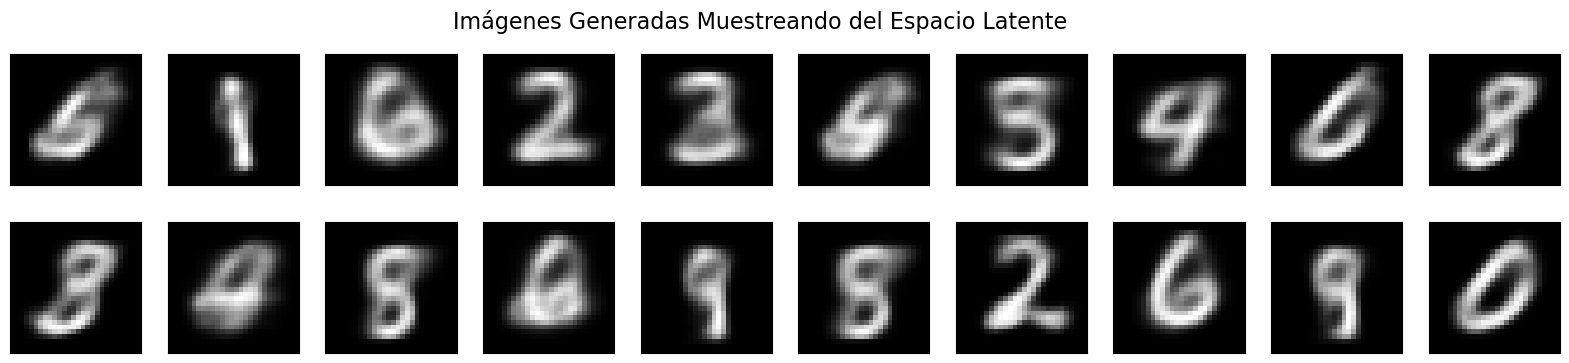

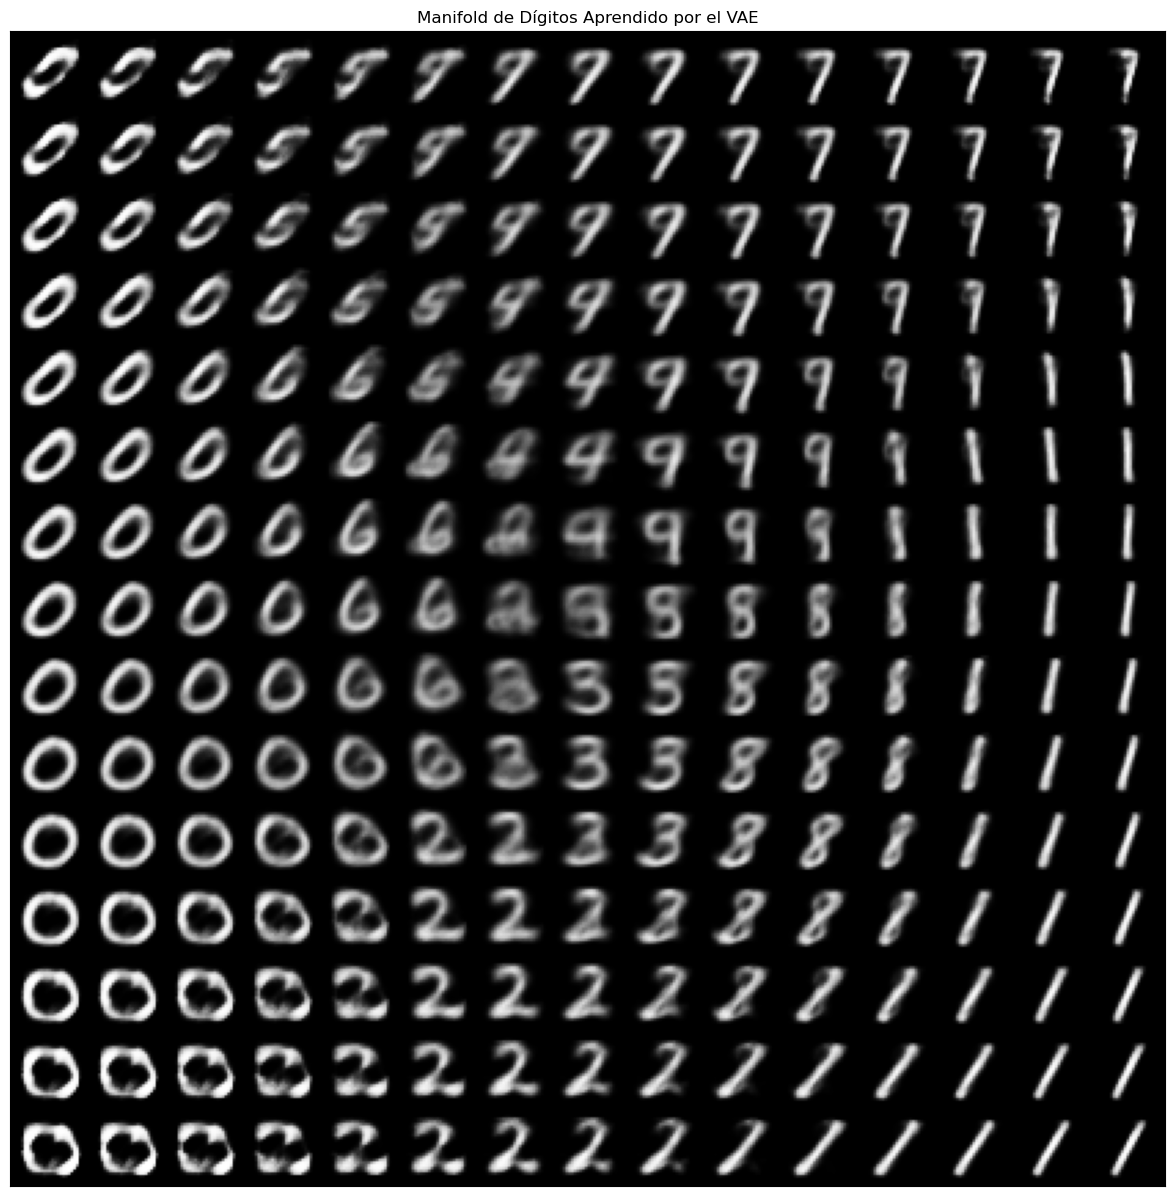

In [4]:
## 6.1. Implementación del VAE en PyTorch

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder_net = nn.Sequential(
            nn.Linear(IMAGE_SIZE, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder_net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, IMAGE_SIZE),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_net(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder_net(z)

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        mu, logvar = self.encode(x_flat)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Función de pérdida del VAE = Pérdida de Reconstrucción + Pérdida KL
def vae_loss_function(recon_x, x, mu, logvar):
    # Usamos BCE para la reconstrucción
    x_flat = x.view(x.size(0), -1)
    BCE = nn.functional.binary_cross_entropy(recon_x, x_flat, reduction='sum')

    # Divergencia KL: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

vae_model = VAE(LATENT_DIM).to(device)
optimizer_vae = torch.optim.Adam(vae_model.parameters(), lr=LEARNING_RATE)
print("\nArquitectura del Variational Autoencoder:")
print(vae_model)

##############################################################################

# ## 6.2. Entrenamiento del VAE

def train_vae(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        recon_batch, mu, logvar = model(X)
        loss = loss_fn(recon_batch, X, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss/len(X):>7f}  [{current:>5d}/{size:>5d}]")

print("\n--- Entrenando Variational Autoencoder ---")
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_vae(train_dataloader, vae_model, vae_loss_function, optimizer_vae)
print("Entrenamiento del VAE completado!")

##############################################################################

# ## 6.3. Evaluación del Espacio Latente y Capacidad Generativa del VAE

def plot_vae_latent_space(model, dataloader):
    model.eval()
    latent_space_mu = []
    labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X_flat = X.view(X.size(0), -1).to(device)
            mu, logvar = model.encode(X_flat)
            latent_space_mu.append(mu.cpu().numpy())
            labels.append(y.numpy())

    latent_space_mu = np.concatenate(latent_space_mu)
    labels = np.concatenate(labels)

    plt.figure(figsize=(10, 8))
    plt.scatter(latent_space_mu[:, 0], latent_space_mu[:, 1], c=labels, cmap='viridis', s=4, alpha=0.7)
    plt.colorbar()
    plt.title('Espacio Latente del VAE')
    plt.xlabel('Dimensión Latente 1 (mu)')
    plt.ylabel('Dimensión Latente 2 (mu)')
    plt.grid(True)
    plt.show()
    print("Observación: El espacio latente está mucho más estructurado y centrado.")
    print("Los clusters son distinguibles y el espacio entre ellos es significativo.")

def plot_reconstructions(ae_model, vae_model, dataloader):
    ae_model.eval()
    vae_model.eval()
    with torch.no_grad():
        # Tomamos un batch de imágenes de prueba
        X, _ = next(iter(dataloader))
        X = X.to(device)

        # Reconstrucción del AE
        recon_ae = ae_model(X).cpu()

        # Reconstrucción del VAE
        recon_vae, _, _ = vae_model(X)
        recon_vae = recon_vae.cpu()

        n = 10
        plt.figure(figsize=(20, 6))
        for i in range(n):
            # Imagen original
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(X[i].cpu().reshape(28, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == 0: ax.set_ylabel("Original", rotation=90, size='large')

            # Reconstrucción AE
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(recon_ae[i].reshape(28, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == 0: ax.set_ylabel("AE Recon", rotation=90, size='large')

            # Reconstrucción VAE
            ax = plt.subplot(3, n, i + 1 + 2 * n)
            plt.imshow(recon_vae[i].reshape(28, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == 0: ax.set_ylabel("VAE Recon", rotation=90, size='large')
        plt.show()


def plot_generated_images(model, n=20):
    model.eval()
    with torch.no_grad():
        # Muestreamos del prior N(0,I)
        z = torch.randn(n, LATENT_DIM).to(device)
        generated = model.decode(z).cpu()

    plt.figure(figsize=(20, 4))
    plt.suptitle("Imágenes Generadas Muestreando del Espacio Latente", fontsize=16)
    for i in range(n):
        ax = plt.subplot(2, n//2, i + 1)
        plt.imshow(generated[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot_latent_manifold(model, n=15, figsize=15):
    # Muestra el "manifold" de dígitos aprendido
    model.eval()
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    # Construimos una rejilla de coordenadas en el espacio latente
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)[::-1]

    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                x_decoded = model.decode(z_sample)
                digit = x_decoded[0].cpu().reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title("Manifold de Dígitos Aprendido por el VAE")
    plt.imshow(figure, cmap='gray')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

# Ejecutar visualizaciones para el VAE
plot_reconstructions(ae_model, vae_model, test_dataloader)
plot_vae_latent_space(vae_model, test_dataloader)
plot_generated_images(vae_model)
plot_latent_manifold(vae_model)



## 7. Conclusiones

Hemos comparado un Autoencoder básico con un Autoencoder Variacional.

1.  **Espacio Latente:** El AE produce un espacio latente desorganizado y con
    "agujeros". El VAE, gracias a la regularización impuesta por la divergencia KL,
    genera un espacio latente **continuo y estructurado**, donde las codificaciones
    siguen la distribución *prior* $\mathcal{N}(0, I)$.

2.  **Generación:** La estructura del espacio latente del VAE le permite funcionar
    como un potente modelo generativo. Al muestrear un vector $z$ del prior y
    pasarlo por el decoder, podemos generar nuevas muestras que se asemejan a los
    datos de entrenamiento. El AE no puede hacer esto de forma fiable.

3.  **Fundamento Teórico:** El VAE se fundamenta en los principios de la
    inferencia variacional bayesiana, lo que le confiere una base teórica
    sólida. Su función de pérdida, el negativo del ELBO, es una cota inferior
    de la log-verosimilitud de los datos, lo que conecta directamente el
    entrenamiento con un objetivo probabilístico bien definido.

El VAE representa un puente elegante entre el aprendizaje profundo y los
modelos gráficos probabilísticos, abriendo la puerta a modelos generativos
aún más complejos y capaces.